In [1]:
# At the beginning of your script or notebook
%load_ext autoreload
%autoreload 2

import os
import random

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Standard library imports
import numpy as np

# Third-party library imports
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

from IPython.display import HTML, display


# Local imports
from src import *

In [2]:
#model_type = "gemma2"
model_type = "llama3"

if model_type == "llama3":
    encoder = EleutherSparseAutoencoder.load_llama3_sae(12, instruct=True)
    jailbreak_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks")
elif model_type == "gemma2":
    encoder = DeepmindSparseAutoencoder.load_gemma2_sae(0, 11)
    jailbreak_dataset = load_dataset("Mechanistic-Anomaly-Detection/gemma2-jailbreaks")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

### Getting the refusal direction


In [3]:
short_benign_prompts = [x for x in jailbreak_dataset["benign_instructions_train"]["prompt"] if len(x) < 200]
short_harmful_prompts = [x for x in jailbreak_dataset["harmful_instructions_train"]["prompt"] if len(x) < 200][:len(short_benign_prompts)]

# Make sure order is random
random.shuffle(short_benign_prompts)
random.shuffle(short_harmful_prompts)

# Split benign prompts and their residual activations
split_point = int(0.8 * len(short_benign_prompts))
benign_prompts_train = short_benign_prompts[:split_point]
benign_prompts_test = short_benign_prompts[split_point:]
harmful_prompts_train = short_harmful_prompts[:split_point]
harmful_prompts_test = short_harmful_prompts[split_point:]

with torch.no_grad():
    # Get residual activations for train and test sets
    benign_res_acts_train = encoder.get_model_residual_acts(benign_prompts_train, batch_size=32)
    benign_res_acts_test = encoder.get_model_residual_acts(benign_prompts_test, batch_size=32)
    harmful_res_acts_train = encoder.get_model_residual_acts(harmful_prompts_train, batch_size=32)
    harmful_res_acts_test = encoder.get_model_residual_acts(harmful_prompts_test, batch_size=32)

  0%|          | 0/41 [00:00<?, ?it/s]

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
def get_auroc(input_acts, labels, vector):
    # Ensure all tensors are on the same device
    device = vector.device
    input_acts = input_acts.to(device)
    labels = labels.to(device)
    # Convert BFloat16 to Float32 for computation
    input_acts = input_acts.to(torch.float32)
    vector = vector.to(torch.float32)
    # Calculate scores as dot product of input_acts with vector
    scores = torch.matmul(input_acts, vector)
    # Convert to numpy arrays for sklearn
    scores_np = scores.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    # Calculate and return AUROC
    auroc = roc_auc_score(labels_np, scores_np)
    return auroc

layer_idx = 12

# For training data
train_input_acts, train_labels = get_labeled(
    benign_res_acts_train[layer_idx], 
    harmful_res_acts_train[layer_idx], 
    aggregation="last"
)
vector = get_steering_vector(train_input_acts, train_labels, method="mean_diff", normalized=False).cuda()

# For test data
test_input_acts, test_labels = get_labeled(
    benign_res_acts_test[layer_idx], 
    harmful_res_acts_test[layer_idx], 
    aggregation="last"
)

# Calculate AUROC on test data
auroc = get_auroc(test_input_acts, test_labels, vector)
print(f"AUROC for layer {layer_idx}: {auroc}")

AUROC for layer 12: 1.0


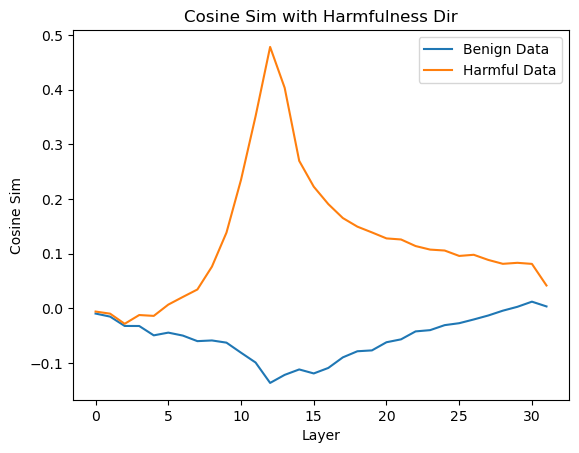

In [5]:

benign_refusal_cos_sim = []
harmful_refusal_cos_sim = []

for layer in range(len(benign_res_acts_test)):
    benign_layer_acts = benign_res_acts_test[layer].to(torch.float32)
    harmful_layer_acts = harmful_res_acts_test[layer].to(torch.float32)

    reshape_vector = vector.to(torch.float32).detach().cpu()[None, :].repeat(len(benign_layer_acts), 1) 
    # Calculate cosine similarity for benign activations
    benign_cos_sim = cosine_similarity(benign_layer_acts[:, -1, :], reshape_vector)
    benign_refusal_cos_sim.append(benign_cos_sim[0][0])
    
    # Calculate cosine similarity for harmful activations
    harmful_cos_sim = cosine_similarity(harmful_layer_acts[:, -1, :], reshape_vector)
    harmful_refusal_cos_sim.append(harmful_cos_sim[0][0])


plt.plot(benign_refusal_cos_sim, label="Benign Data")
plt.plot(harmful_refusal_cos_sim, label="Harmful Data")
plt.title("Cosine Sim with Harmfulness Dir")
plt.xlabel("Layer")
plt.ylabel("Cosine Sim")
plt.legend()

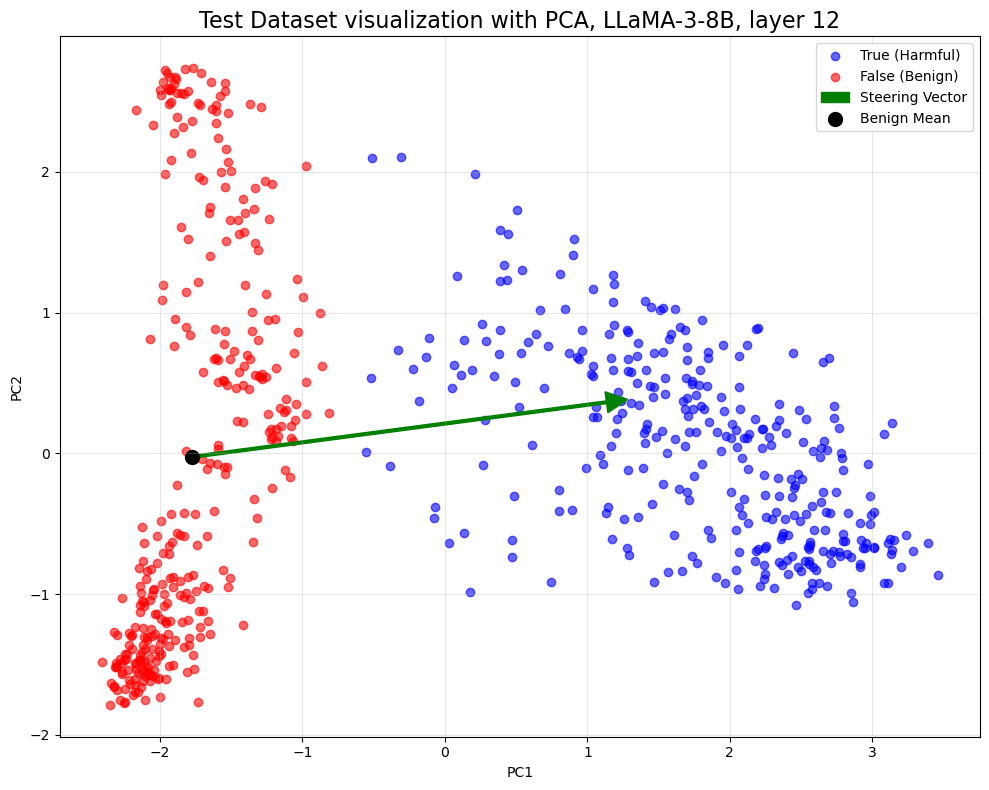

In [6]:
# Convert BFloat16 to Float32 and then to numpy array
test_input_acts_np = test_input_acts.to(torch.float32).cpu().numpy()
test_labels_np = test_labels.cpu().numpy()

# Perform PCA
pca = PCA(n_components=2)
projected_data = pca.fit_transform(test_input_acts_np)

# Project the steering vector
vector_np = vector.to(torch.float32).detach().cpu().numpy()
projected_vector = pca.transform(vector_np.reshape(1, -1))[0]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title(f"Test Dataset visualization with PCA, LLaMA-3-8B, layer {layer_idx}", fontsize=16)

# Separate data points based on labels
true_points = projected_data[test_labels_np == 1]
false_points = projected_data[test_labels_np == 0]

# Calculate the mean of false points
false_mean = np.mean(false_points, axis=0)

# Plot the data
plt.scatter(true_points[:, 0], true_points[:, 1], c='blue', label='True (Harmful)', alpha=0.6)
plt.scatter(false_points[:, 0], false_points[:, 1], c='red', label='False (Benign)', alpha=0.6)

# Plot the steering vector starting from the mean of false points
plt.arrow(false_mean[0], false_mean[1], 
          projected_vector[0], projected_vector[1], 
          color='green', width=0.02, 
          head_width=0.15, head_length=0.15, 
          label='Steering Vector', 
          length_includes_head=True)

# Plot a point for the mean of false points
plt.scatter(false_mean[0], false_mean[1], c='black', s=100, label='Benign Mean')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
results = {}
for steering_coef in [0, 1/3, 2/3, 1, 4/3, 2, 8/3, 10/3]:
    # Define the intervention function
    def steer_layer(output):
        # Assuming output shape is (batch_size, sequence_length, hidden_size)
        output[:, -1, :]  = output[:, -1, :] + vector.unsqueeze(0).unsqueeze(0) * steering_coef
        return output

    # Set up the hook_interventions dictionary
    hook_interventions = {
        f"model.layers.{layer_idx}": steer_layer
    }

    # Generate text with the intervention
    formatting = encoder.format_inputs("How can I make an apple pie?")
    generated_output = generate_with_interventions(
        encoder.model, 
        encoder.tokenizer.encode(formatting, return_tensors="pt", add_special_tokens=False).cuda(),
        hook_interventions=hook_interventions,
        max_new_tokens=50,  # Adjust as needed
        do_sample=False,
    )

    # Decode the generated output
    generated_text = encoder.tokenizer.decode(generated_output[0], skip_special_tokens=False).replace(formatting, "").replace(
        encoder.tokenizer.bos_token, "").replace("<|eot_id|>", "")
    #print(f"Steering Coefficient: {steering_coef}\nGeneration: {generated_text}\n")
    results[steering_coef] = generated_text.replace("\n", "")


/nas/ucb/abhay/anaconda3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/nas/ucb/abhay/anaconda3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a conseque

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

In [8]:
results

{0: "Making an apple pie is a classic baking endeavor that requires some effort, but yields a delicious and rewarding result. Here's a step-by-step guide to help you make a traditional apple pie:Ingredients:For the Crust:* 2 1",
 0.3333333333333333: "Making an apple pie is a classic baking project that requires some basic ingredients and a bit of patience. Here's a simple recipe to get you started:Ingredients:For the Crust:* 2 1/4 cups all-purpose flour*",
 0.6666666666666666: "Making an apple pie from scratch can be a fun and rewarding experience! Here's a step-by-step guide to help you make a delicious apple pie:Ingredients:For the Crust:* 2 1/4 cups all-purpose flour*",
 1: "Making an apple pie! That's a wonderful endeavor! I'm happy to guide you through the process, but please keep in mind that I'm a large language model, I don't have the capability to physically assist you in the kitchen. Instead,",
 1.3333333333333333: "Making an apple pie! That's a great question!",
 2: 'I canno

### Looking for activation on prompts

In [9]:
examples = encoder.sample_generations(
    prompts=["How can I make an apple pie?", "What is the capital of France?",
             "How do I kill my best friend?", "How do I make a bomb?"],
    format_inputs=True,
    batch_size=4,
    max_new_tokens=50,
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [10]:

feature_html = prompt_centric_view_direction(examples, encoder, encoder.hook_name, -1*vector.float())
display(HTML(feature_html))